In [2]:
import os

In [3]:
%load_ext autoreload
%autoreload 0
%matplotlib inline

from pianoq.simulations.mplc_sim.mplc_scaling import MPLCScalingSimulation
from pianoq.simulations.mplc_sim.mplc_utils import show_field, show_mask, corr
from pianoq.misc.mplt import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['image.cmap'] = 'viridis'

can't use vimba camera
can't import TimeTagger
could not import ThorlabsRotatingServoMotor


## Debug

In [ ]:
plt.close('all')
path = r"C:\temp\mplcs\2024_09_03_16_05_24_diffuser.masks"
s = MPLCScalingSimulation(path)
s.set_intial_spot(sig=0.1e-3, Dx0=-0.0, Dy0=-1.1e-3)
# show_field(s.initial_field, active_slice=s.res.active_slice, title='initial field')
# show_field(s.mplc.propagate_mplc(s.initial_field, 10, 8, backprop=False), active_slice=s.res.active_slice, title='lense plane')
# show_field(s.mplc.propagate_mplc(s.initial_field, 10, 6, backprop=False), active_slice=s.res.active_slice, title='start diffuser')
E_plane_0 = s.mplc.propagate_mplc(s.initial_field, 10, 0, backprop=False, prop_first_mask=False, prop_last_mask=True)
# show_field(E_plane_0, figshow=False, active_slice=s.res.active_slice, title='end diffuser')
E_fliped = np.fliplr(np.flipud(E_plane_0))
# show_field(E_fliped, figshow=False, active_slice=s.res.active_slice, title='fliped')
E_back = s.mplc.propagate_mplc(E_fliped, 0, 10, backprop=False, prop_first_mask=True, prop_last_mask=False)
# show_field(E_back, figshow=False, active_slice=s.res.active_slice, title='final')
speckles = s.propagate_klyshko()
show_field(speckles, False, active_slice=s.res.active_slice, title='speckles')

# Test Klyshko things

In [4]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\masks\2024_09_05_10_19_15_diffuser.masks"
s = MPLCScalingSimulation(path)
s.set_intial_spot(sig=0.1e-3, Dx0=-0.0, Dy0=-1.1e-3)
s.set_out_desired_spot(sig=0.1e-3, Dx0=0.0, Dy0=1.1e-3)
speckles = s.propagate_klyshko()

fixing_phase_slm1 = s.get_fixing_phase_SLM(s.SLM1_plane)
fixing_phase_slm2 = s.get_fixing_phase_SLM(s.SLM2_plane)
s.slm1_phase = fixing_phase_slm1
s.slm2_phase = fixing_phase_slm2

fixed_SLM1 = s.propagate_klyshko(use_slm1=True)
fixed_SLM2 = s.propagate_klyshko(use_slm2=True)

C:\code\pianoq\pianoq\simulations\mplc_sim\mplc_utils.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\code\pianoq\pianoq\simulations\mplc_sim\mplc_utils.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


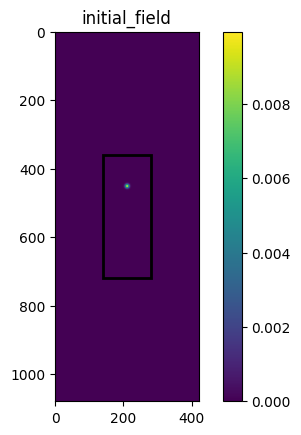

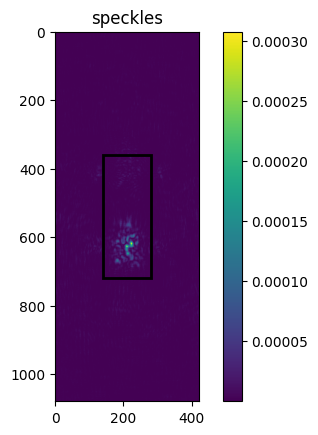

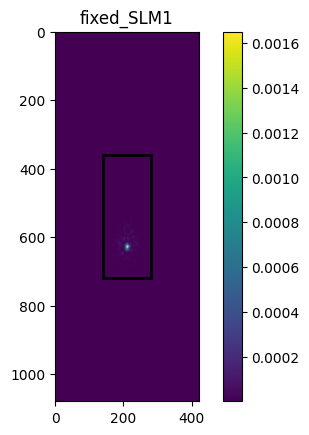

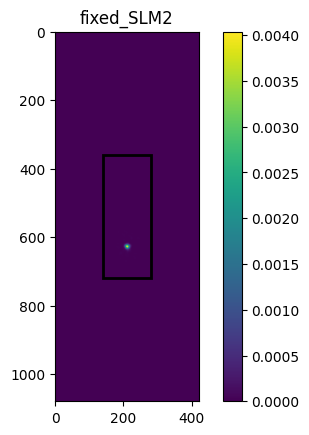

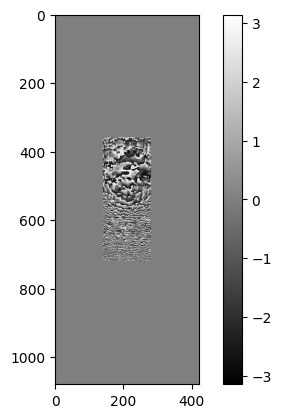

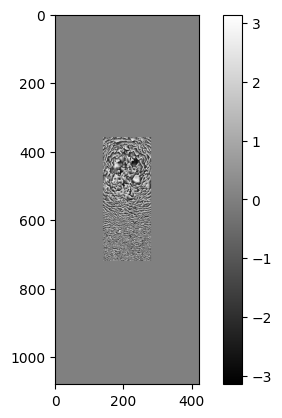

In [5]:
show_field(s.initial_field, active_slice=s.mplc.res.active_slice, title='initial_field')
show_field(speckles, False, active_slice=s.res.active_slice, title='speckles')
show_field(fixed_SLM1, False, active_slice=s.res.active_slice, title='fixed_SLM1')
show_field(fixed_SLM2, False, active_slice=s.res.active_slice, title='fixed_SLM2')
show_mask(np.angle(fixing_phase_slm1))
show_mask(np.angle(fixing_phase_slm2))


# Degrees of control

In [6]:
weighted = False 
Is_slm1 = []
Is_slm2 = []
fixed_SLM1s = []
fixed_SLM2s = []
DOCs = 1/np.arange(1, 20)
overlap1 = s.get_overlap_at_plane(s.SLM1_plane)
overlap2 = s.get_overlap_at_plane(s.SLM2_plane)

ind_row, ind_col = np.unravel_index(np.argmax(np.abs(s.out_desired_spot), axis=None), s.out_desired_spot.shape)
x_center = s.mplc.XX[ind_row, ind_col] 
y_center = s.mplc.YY[ind_row, ind_col]
mask = (s.mplc.XX - x_center)**2 + (s.mplc.YY - y_center)**2 < (100e-6)**2
# mimshow(mask)

In [7]:
for DOC in tqdm(DOCs):
    s.slm1_phase = s.get_mask_with_degree_of_control(overlap1, DOC, weighted=weighted)
    s.slm2_phase = s.get_mask_with_degree_of_control(overlap2, DOC, weighted=weighted)

    fixed_SLM1 = s.propagate_klyshko(use_slm1=True)
    fixed_SLM2 = s.propagate_klyshko(use_slm2=True)
    
    fixed_SLM1s.append(fixed_SLM1)
    fixed_SLM2s.append(fixed_SLM2)
    
    I_slm1 = (np.abs(fixed_SLM1*mask)**2).sum()
    I_slm2 = (np.abs(fixed_SLM2*mask)**2).sum()
    Is_slm1.append(I_slm1)
    Is_slm2.append(I_slm2)

100%|██████████| 19/19 [00:42<00:00,  2.22s/it]


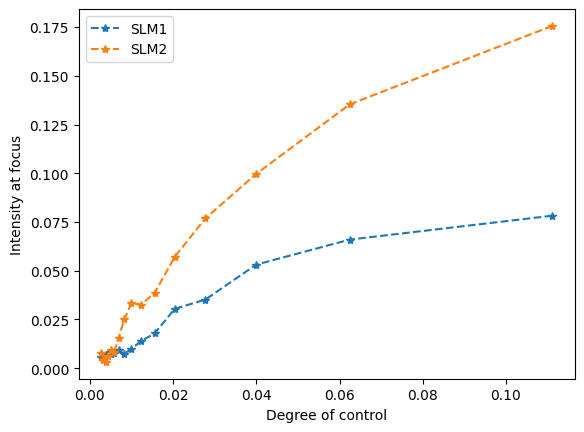

In [17]:
plt.close('all')
N = 2
actual_DOCs = DOCs**2
fig, ax = plt.subplots()
ax.set_xlabel('Degree of control')
ax.set_ylabel('Intensity at focus')
ax.plot(actual_DOCs[N:], Is_slm1[N:], '*--', label='SLM1')
ax.plot(actual_DOCs[N:], Is_slm2[N:], '*--', label='SLM2')
ax.legend()

In [60]:
i = 15
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.abs(fixed_SLM1s[i][s.res.active_slice])**2)
axes[1].imshow(np.abs(fixed_SLM2s[i][s.res.active_slice])**2)
axes[0].set_title(f'SLM1. DOC={DOCs[i]:.3f}')
axes[1].set_title(f'SLM2. DOC={DOCs[i]:.3f}')
